# Feature Importance

imports


In [2]:
# Standard library and other common packages
import glob
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import pandas as pd
import seaborn as sns
from itertools import combinations
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed,
    LSTM,
    Dense,
    Flatten,
    Conv1D,
    Reshape,
    Dropout,
    Concatenate,
)
from PIL import Image, ImageFont
from scipy import stats
import sklearn

# other packages
import dask.dataframe as dd
import neptune.new as neptune
import statsmodels.api as sm
from statsmodels.formula.api import ols
import h5py
from tqdm.notebook import tqdm

# local files
import constants
import utils
from solarprophet import TabularTest

In [3]:
# misc declarations
pd.options.display.max_rows = 300
pd.options.display.max_columns = 300
pd.plotting.register_matplotlib_converters()

rng = np.random.default_rng(seed=42)

sns.set_style("whitegrid")
# sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
# sns.set_palette("colorblind")
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
sns.set_style({"xtick.bottom": True, "ytick.left": True})

plt.rc("font", family="sans-serif")
plt.rc("xtick", labelsize="small")
plt.rc("ytick", labelsize="small")

import data


In [4]:
data_df = utils.load_joint_data(constants.JOINT_DATA_H5_PATH)
for i in range(12):
    time_shift = i * 10 + 10

    data_df[f"GHI t+{time_shift}"] = data_df["GHI"].shift(-time_shift)
    data_df[f"clearsky ghi t+{time_shift}"] = data_df["clearsky ghi"].shift(-time_shift)

    data_df[f"dGHI t+{time_shift}"] = data_df["GHI"].diff(time_shift)
    data_df[f"dclearsky ghi t+{time_shift}"] = data_df["clearsky ghi"].diff(time_shift)
data_df.shape

Loading .h5 dataset


(2630880, 182)

to test single-feature importance, we will set a feature to random numbers rather than the measured values to determine the impact of each feature. Note, that this does not imply that for another model these features are not important, nor does it fully account for co-linearities or shared information

Calculate Spearman's rank correlation coefficient. Pearson's rank coefficient calculates linear correlation independent of scale while Spearman's coefficient calculates monotonic correlation even in nonlinear cases.

Nevermind. Spearman Correlation taking FOREVER. Taking a sample of the data - 100,000 points (~100 sec)


In [5]:
corr = data_df.sample(100000).corr(method="spearman")

<AxesSubplot:>

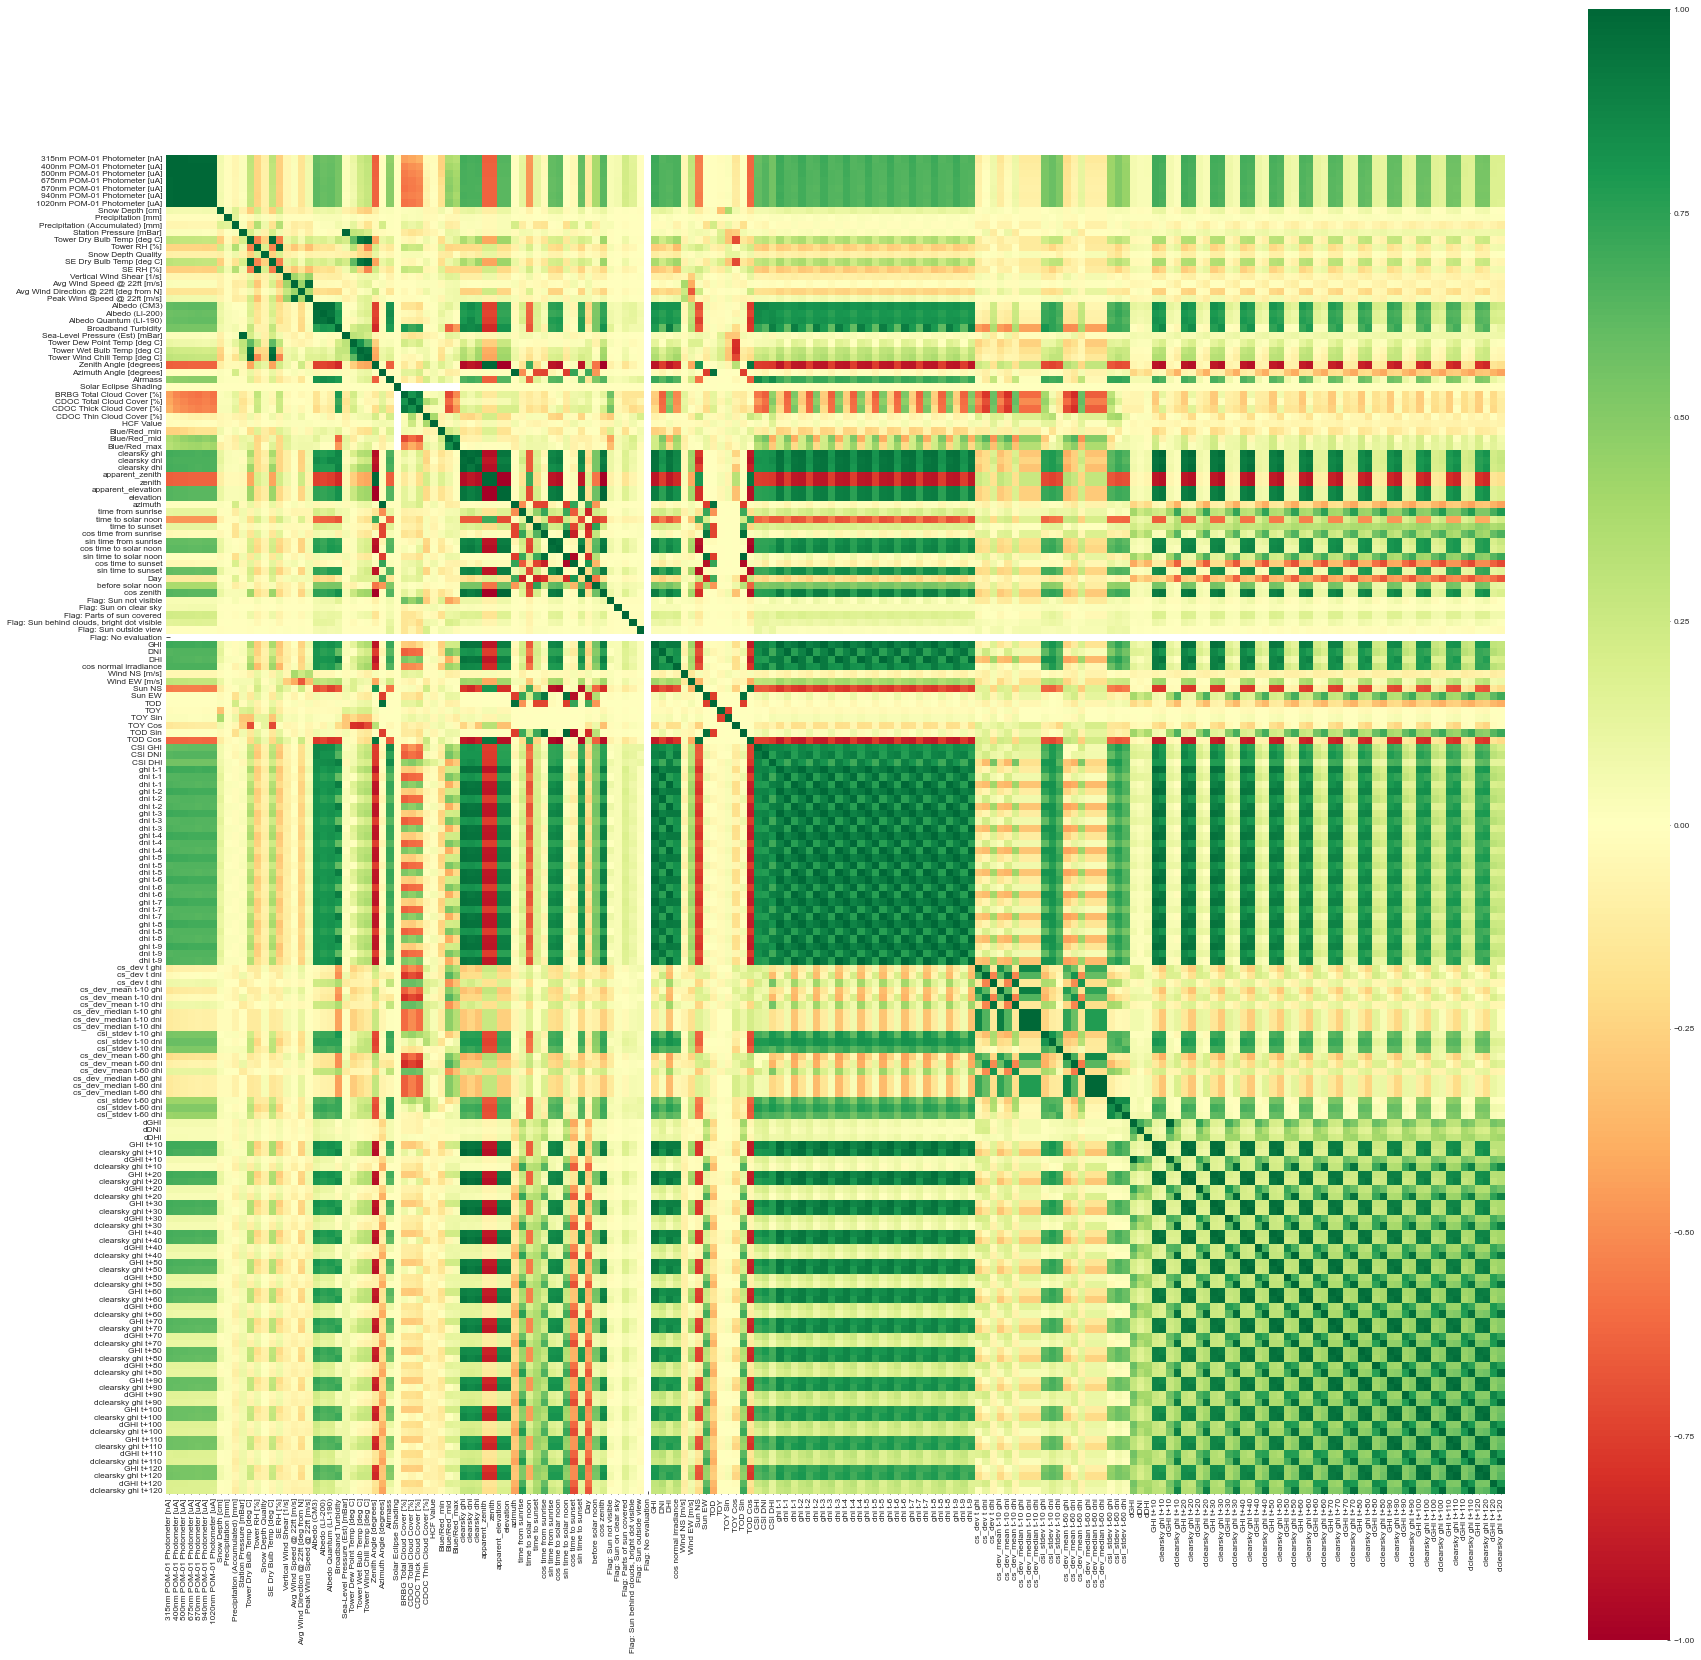

In [6]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    ax=ax,
    square=True,
    cmap="RdYlGn",
)

In [7]:
target_corr = corr[[f"GHI t+{i}" for i in range(10, 121, 10)]]

In [8]:
# main diagonal is correlation with self. since the matric is symmetric, we only need to plot the upper triangle
upper_triangle = np.triu(np.ones(corr.shape), k=1).astype(bool)
upper_triangle_df = corr.where(upper_triangle)

In [9]:
# TODO identify highest and lowest correlations with features, and responses
# TODO identify features by added information theory

In [ ]:
model_runs = {
    "GHI": "SOL-8",
    "Delta CSI GHI": "SOL-9",
    "Delta GHI": "SOL-48",  # two points did not converge in first trial
    "cs_dev t ghi": "SOL-11",
    "CSI GHI": "SOL-12",
}

Test model performance


Shuffling window order should be best because then I don't have to worry about distribution size, which elements are accounted for, jsut whether the window input actually makes a difference


Note that this is a good way to develop an intuition about what the model uses but importantly: 1, this is dependent on the model accuracy, if a better model used completely different features, the feature importance would be different. Without the true outcome, we would not be able to interperet the effect on the error. We are dependent on the random shuffle to a degree, and correlated features will show up as less important than they otherwise are


GHI
====== Reading windows from cache ======

Done


c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:774: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_datetimes = datetimes[train_mask]
c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:775: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  validate_datetimes = datetimes[validate_mask]


Train windows: 47108

self.train_dates.shape=(47108, 25)

self.train_past_features.shape=(47108, 13, 126)

self.train_future_features.shape=(47108, 12, 0)

self.train_scalar_responses.shape=(47108, 12, 1)

self.train_relative_responses.shape=(47108, 12, 0)

self.train_clear_sky_indexes.shape=(47108, 25)

self.train_clear_sky_irradiances.shape=(47108, 25)
Validate windows: 9155
loading model
	model loaded
Evaluating error metrics
287/287 [==============================] - 1s 3ms/step


  0%|          | 0/126 [00:00<?, ?it/s]

GHI 0
287/287 [==============================] - 1s 3ms/step
Importance: 2.222062525483196
DNI 1
287/287 [==============================] - 1s 2ms/step
Importance: 1.8071675326198573
DHI 2
287/287 [==============================] - 1s 2ms/step
Importance: 0.5002796989247429
ghi t-1 3
287/287 [==============================] - 1s 3ms/step
Importance: 1.9236010689712089
ghi t-2 4
287/287 [==============================] - 1s 2ms/step
Importance: 2.0824483715746283
ghi t-3 5
287/287 [==============================] - 1s 3ms/step
Importance: 1.8695296113984483
ghi t-4 6
287/287 [==============================] - 1s 3ms/step
Importance: 4.977328915030341
ghi t-5 7
287/287 [==============================] - 1s 3ms/step
Importance: 2.1704893084623365
ghi t-6 8
287/287 [==============================] - 1s 3ms/step
Importance: 2.923660421698912
ghi t-7 9
287/287 [==============================] - 1s 3ms/step
Importance: 2.2095689881849836
ghi t-8 10
287/287 [==============================] - 1

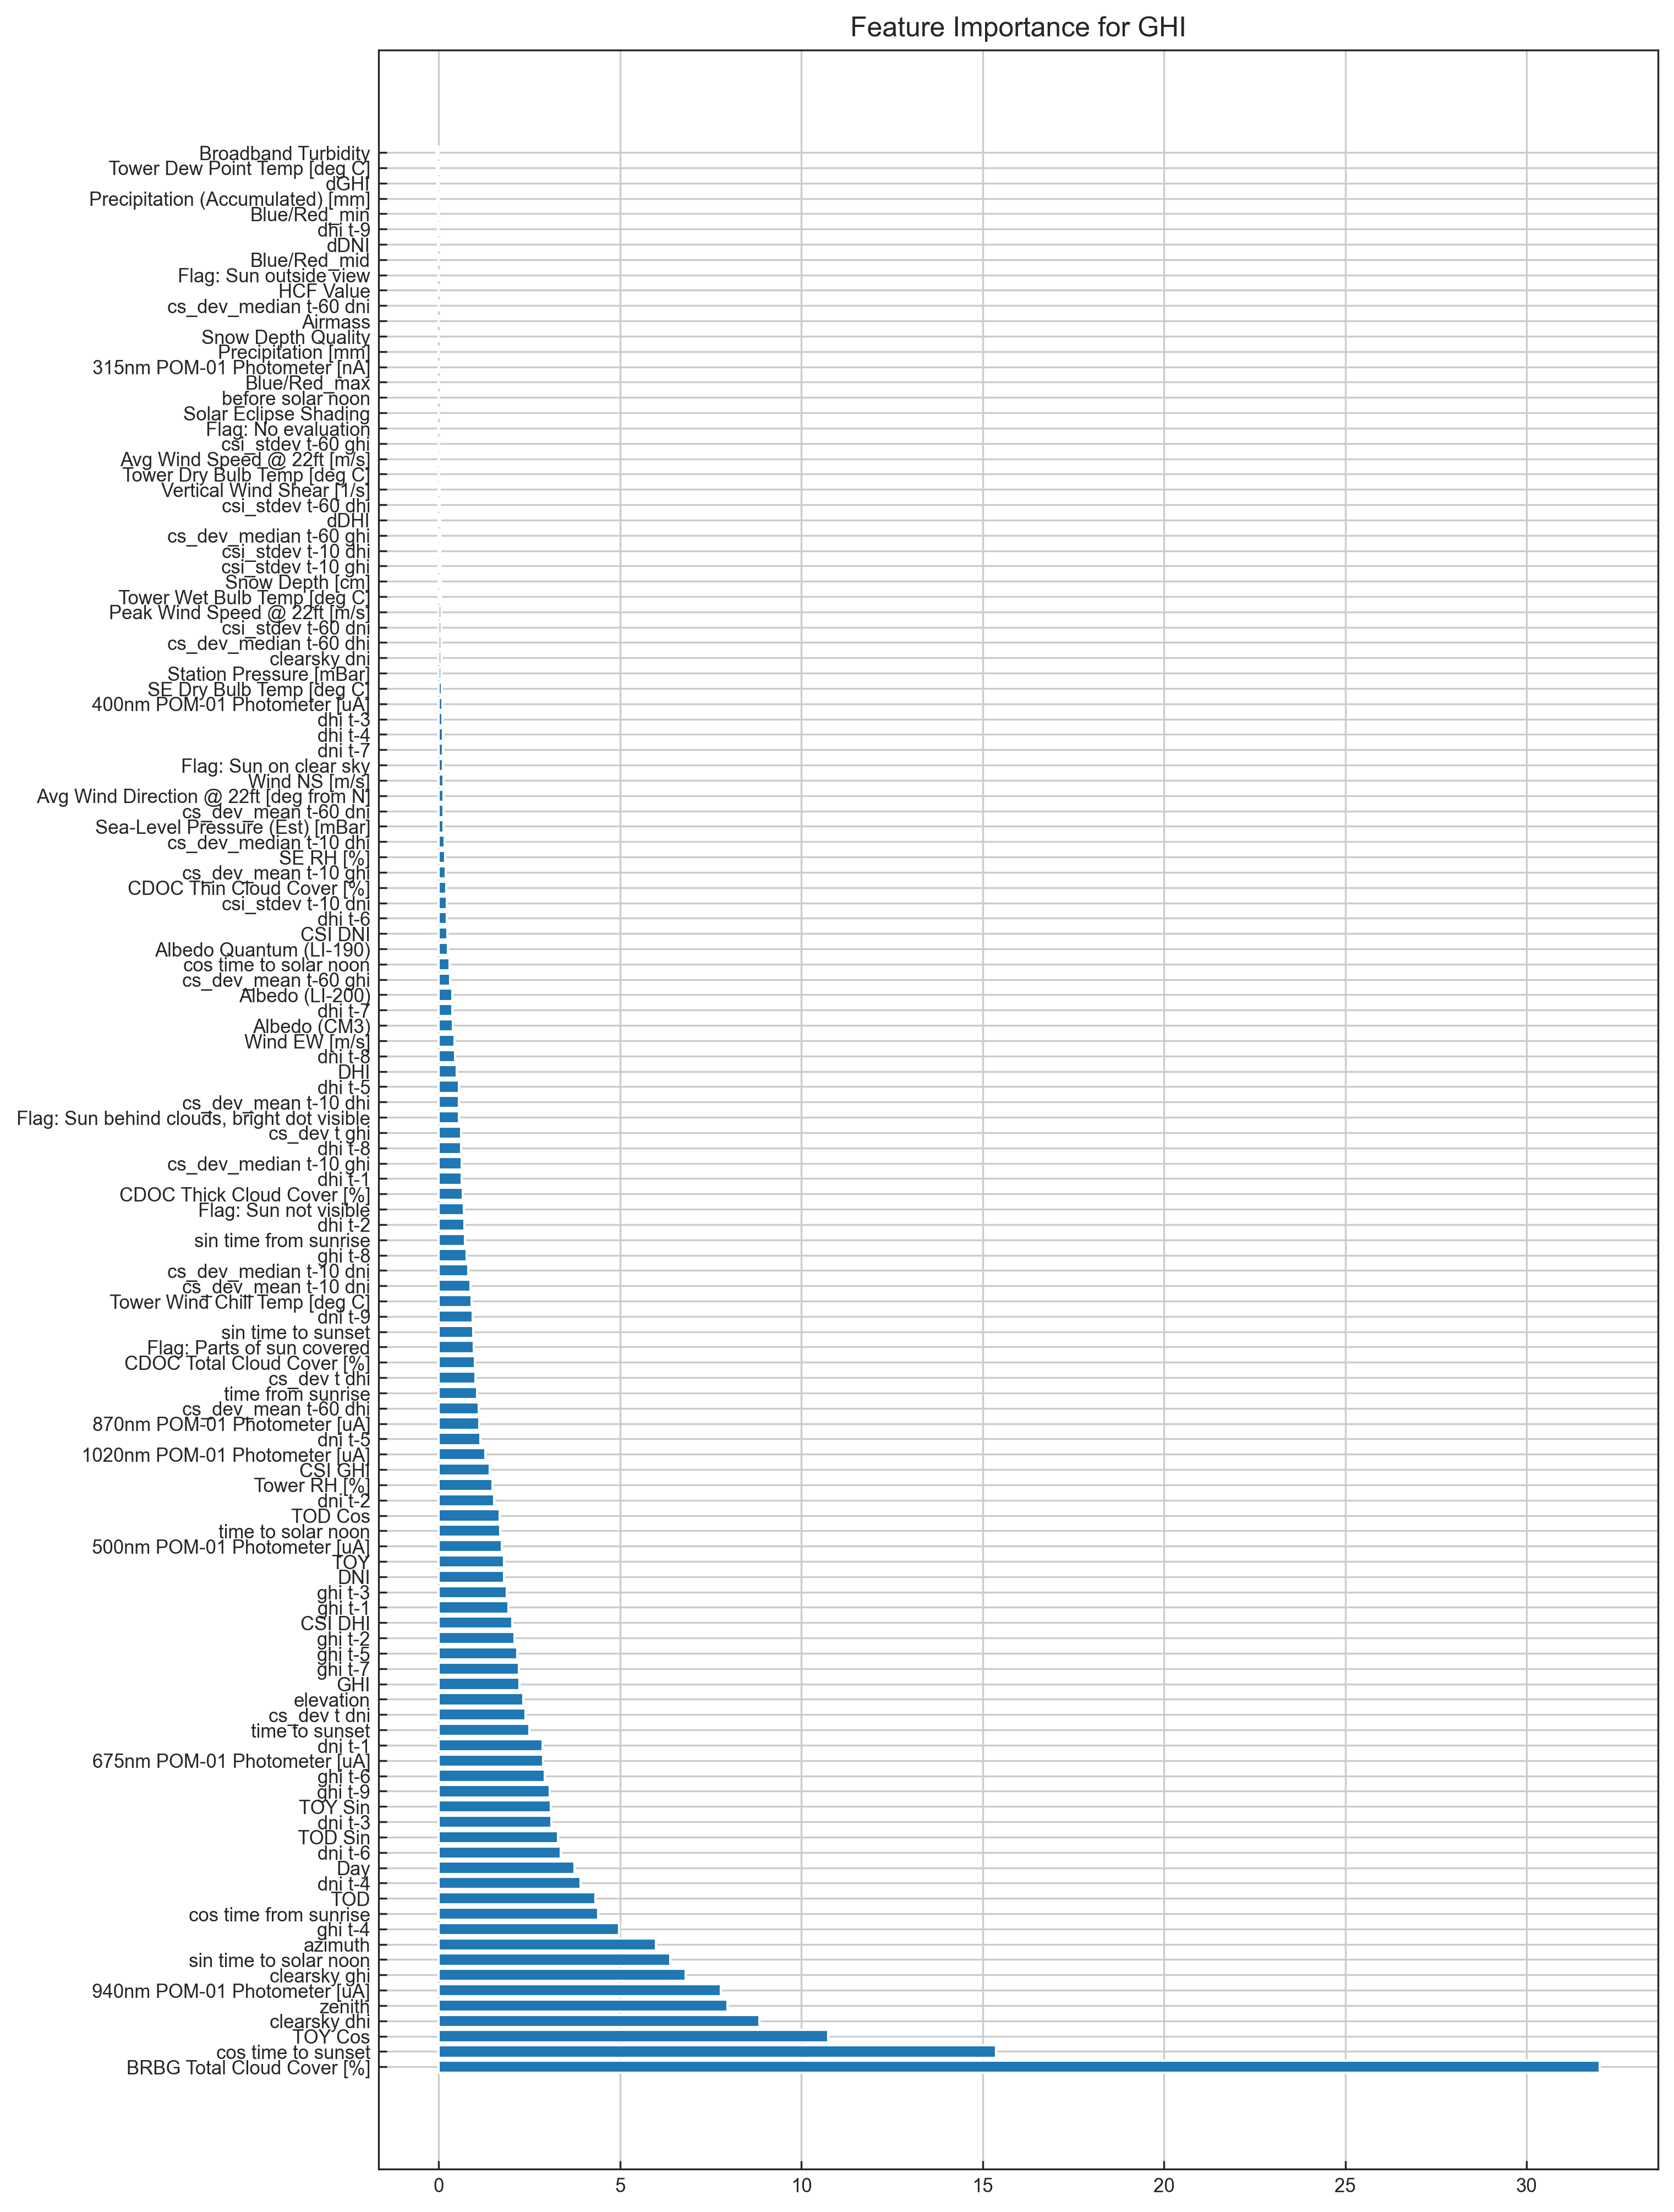

Delta CSI GHI
====== Reading windows from cache ======

Done


c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:774: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_datetimes = datetimes[train_mask]
c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:775: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  validate_datetimes = datetimes[validate_mask]


Relative Response
Train windows: 47108

self.train_dates.shape=(47108, 25)

self.train_past_features.shape=(47108, 13, 126)

self.train_future_features.shape=(47108, 12, 0)

self.train_scalar_responses.shape=(47108, 12, 0)

self.train_relative_responses.shape=(47108, 12, 1)

self.train_clear_sky_indexes.shape=(47108, 25)

self.train_clear_sky_irradiances.shape=(47108, 25)
Validate windows: 9155
loading model
	model loaded
Evaluating error metrics
287/287 [==============================] - 1s 3ms/step


  0%|          | 0/126 [00:00<?, ?it/s]

GHI 0
287/287 [==============================] - 1s 3ms/step
Importance: 2.0847308795374317
DNI 1
287/287 [==============================] - 1s 3ms/step
Importance: 1.9153468660797728
DHI 2
287/287 [==============================] - 1s 3ms/step
Importance: -0.06445476604210398
ghi t-1 3
287/287 [==============================] - 1s 2ms/step
Importance: 0.7467532888934016
ghi t-2 4
287/287 [==============================] - 1s 3ms/step
Importance: 0.2694805161057161
ghi t-3 5
287/287 [==============================] - 1s 2ms/step
Importance: 0.13460332650841167
ghi t-4 6
287/287 [==============================] - 1s 3ms/step
Importance: 0.051753633873332205
ghi t-5 7
287/287 [==============================] - 1s 3ms/step
Importance: 0.06574477875639673
ghi t-6 8
287/287 [==============================] - 1s 3ms/step
Importance: 0.6673697193383816
ghi t-7 9
287/287 [==============================] - 1s 2ms/step
Importance: 0.8802748883539238
ghi t-8 10
287/287 [==========================

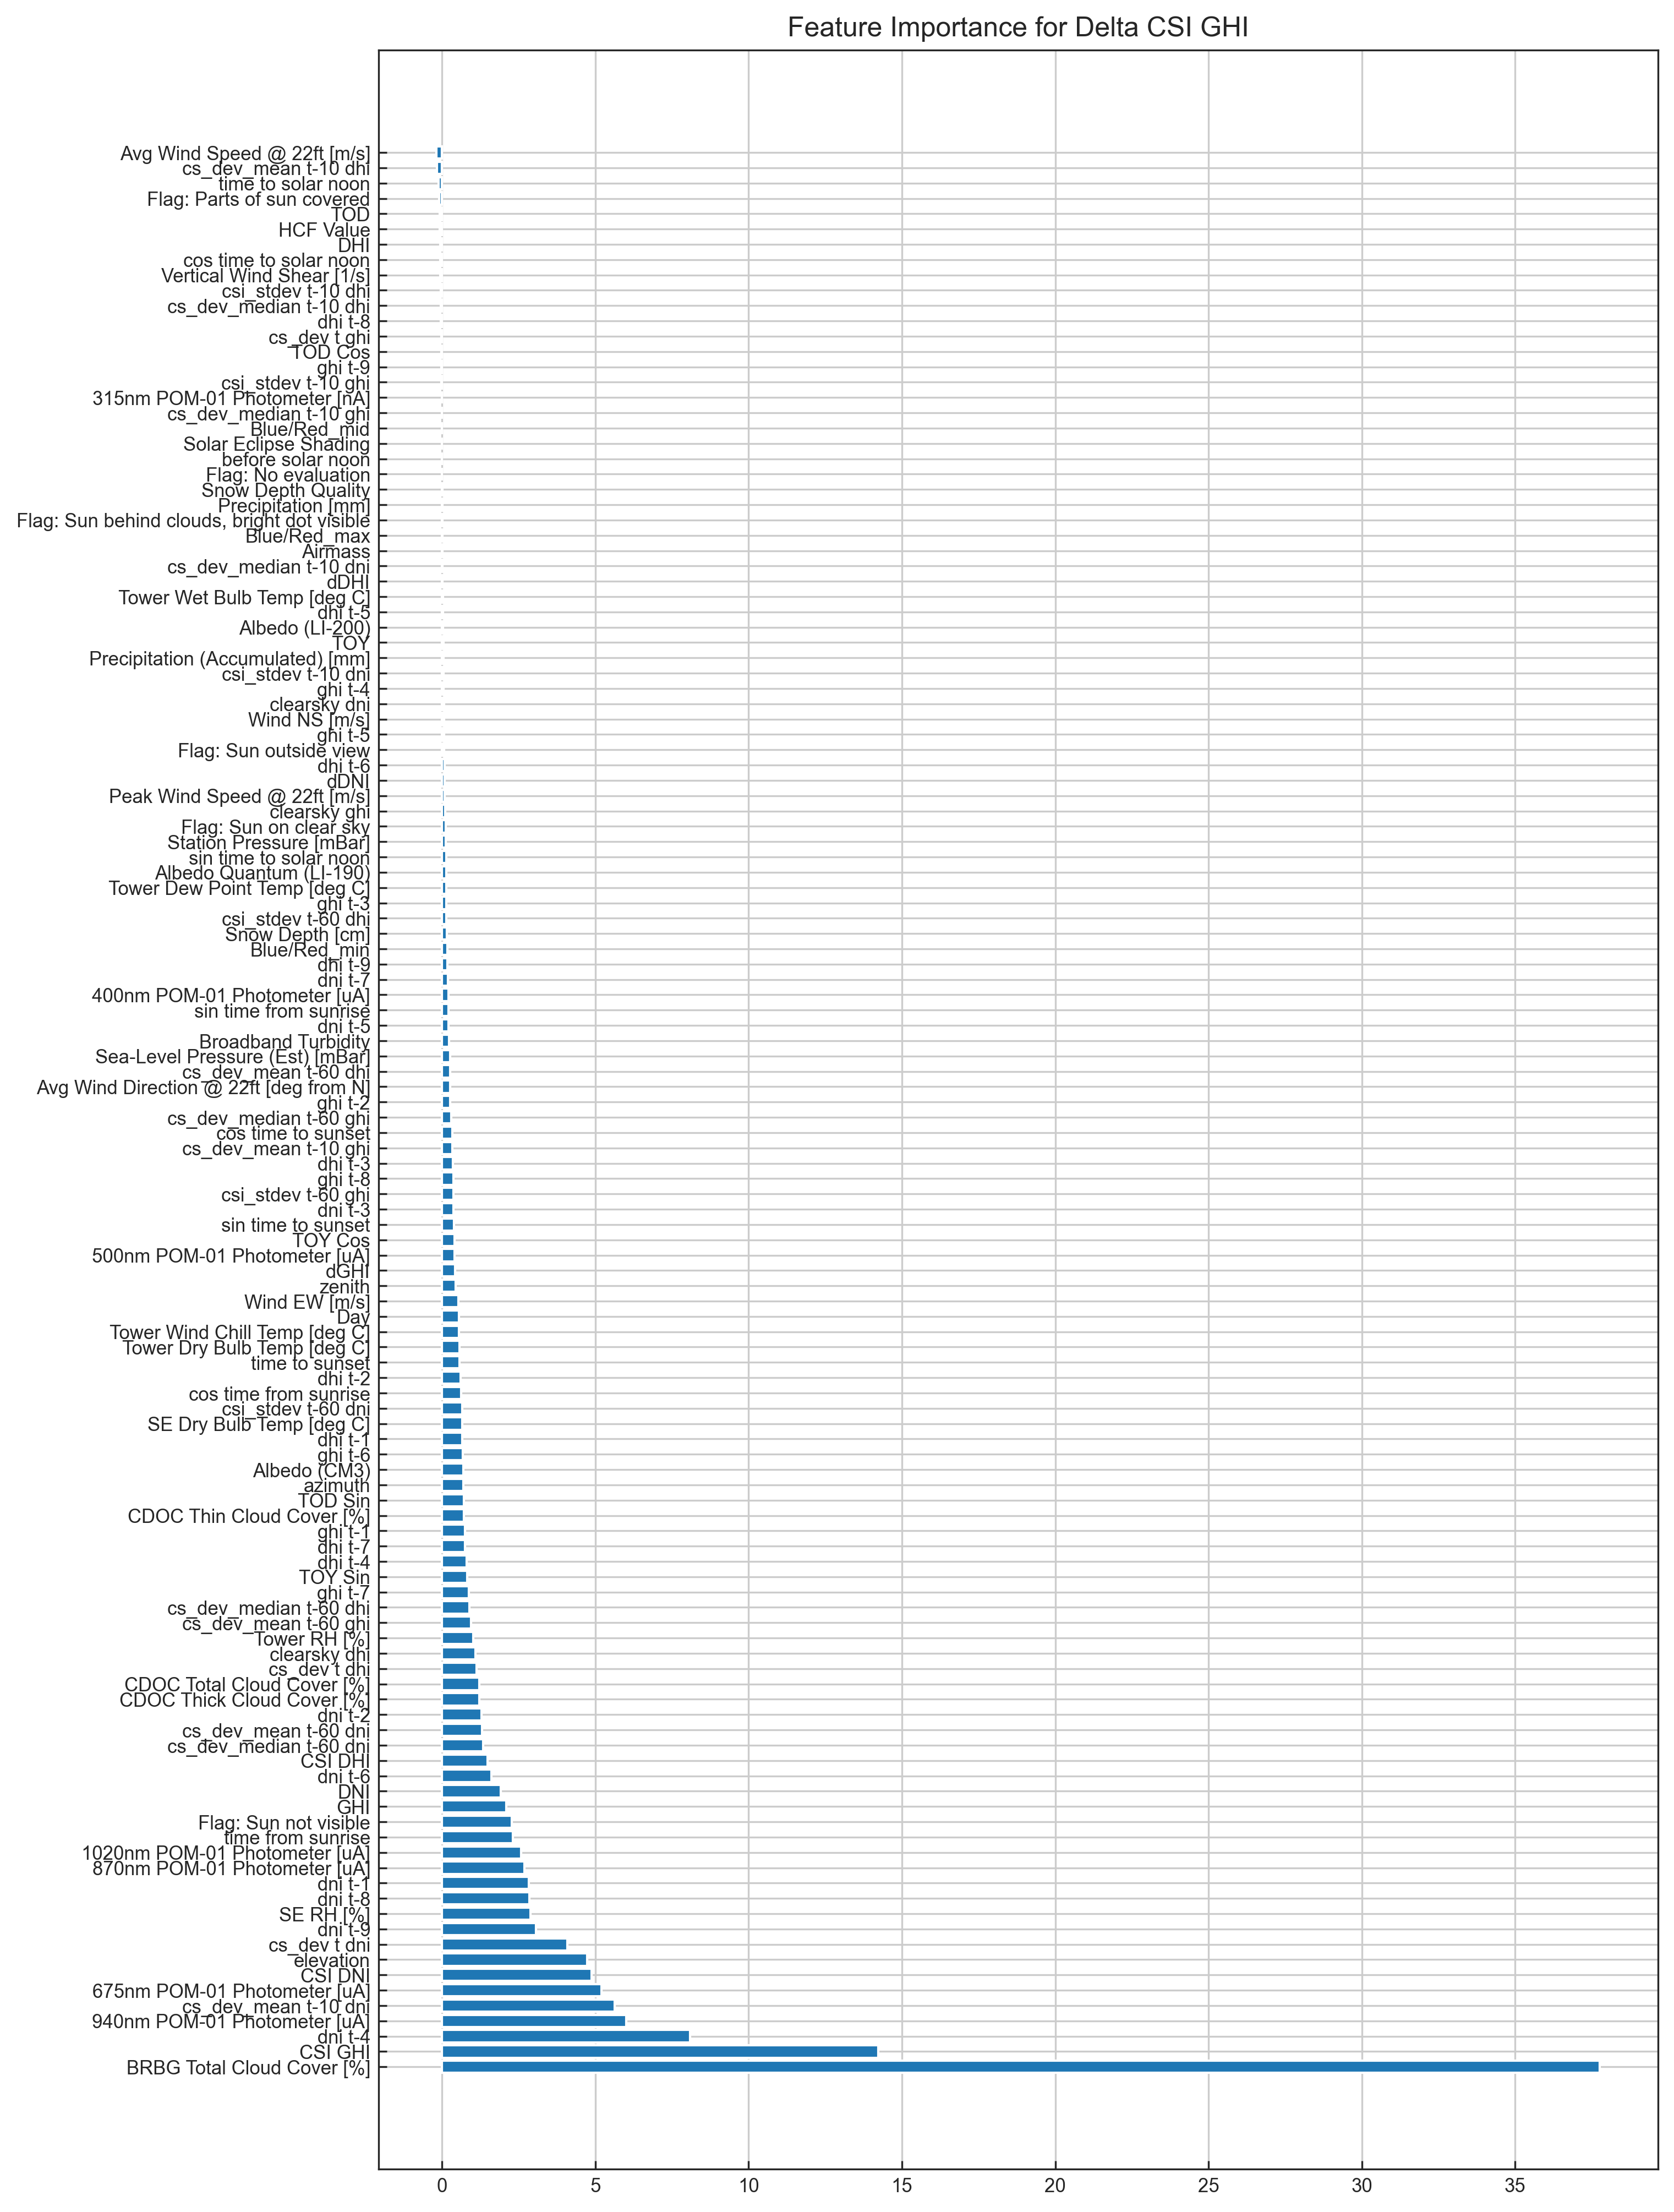

Delta GHI
====== Reading windows from cache ======

Done


c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:774: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_datetimes = datetimes[train_mask]
c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:775: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  validate_datetimes = datetimes[validate_mask]


Relative Response
Train windows: 47108

self.train_dates.shape=(47108, 25)

self.train_past_features.shape=(47108, 13, 126)

self.train_future_features.shape=(47108, 12, 0)

self.train_scalar_responses.shape=(47108, 12, 0)

self.train_relative_responses.shape=(47108, 12, 1)

self.train_clear_sky_indexes.shape=(47108, 25)

self.train_clear_sky_irradiances.shape=(47108, 25)
Validate windows: 9155
loading model
	model loaded
Evaluating error metrics
287/287 [==============================] - 1s 3ms/step


  0%|          | 0/126 [00:00<?, ?it/s]

GHI 0
287/287 [==============================] - 1s 3ms/step
Importance: 1.9730128403107017
DNI 1
287/287 [==============================] - 1s 3ms/step
Importance: 3.316454936394848
DHI 2
287/287 [==============================] - 1s 3ms/step
Importance: 0.5625448925485443
ghi t-1 3
287/287 [==============================] - 1s 3ms/step
Importance: 0.2799566479263973
ghi t-2 4
287/287 [==============================] - 1s 2ms/step
Importance: -0.4466933698913209
ghi t-3 5
287/287 [==============================] - 1s 3ms/step
Importance: -0.3317709455273956
ghi t-4 6
287/287 [==============================] - 1s 3ms/step
Importance: 0.5488642071037191
ghi t-5 7
287/287 [==============================] - 1s 3ms/step
Importance: 0.16690518048352487
ghi t-6 8
287/287 [==============================] - 1s 3ms/step
Importance: 0.3040126797147167
ghi t-7 9
287/287 [==============================] - 1s 2ms/step
Importance: 3.930061061336886
ghi t-8 10
287/287 [==============================]

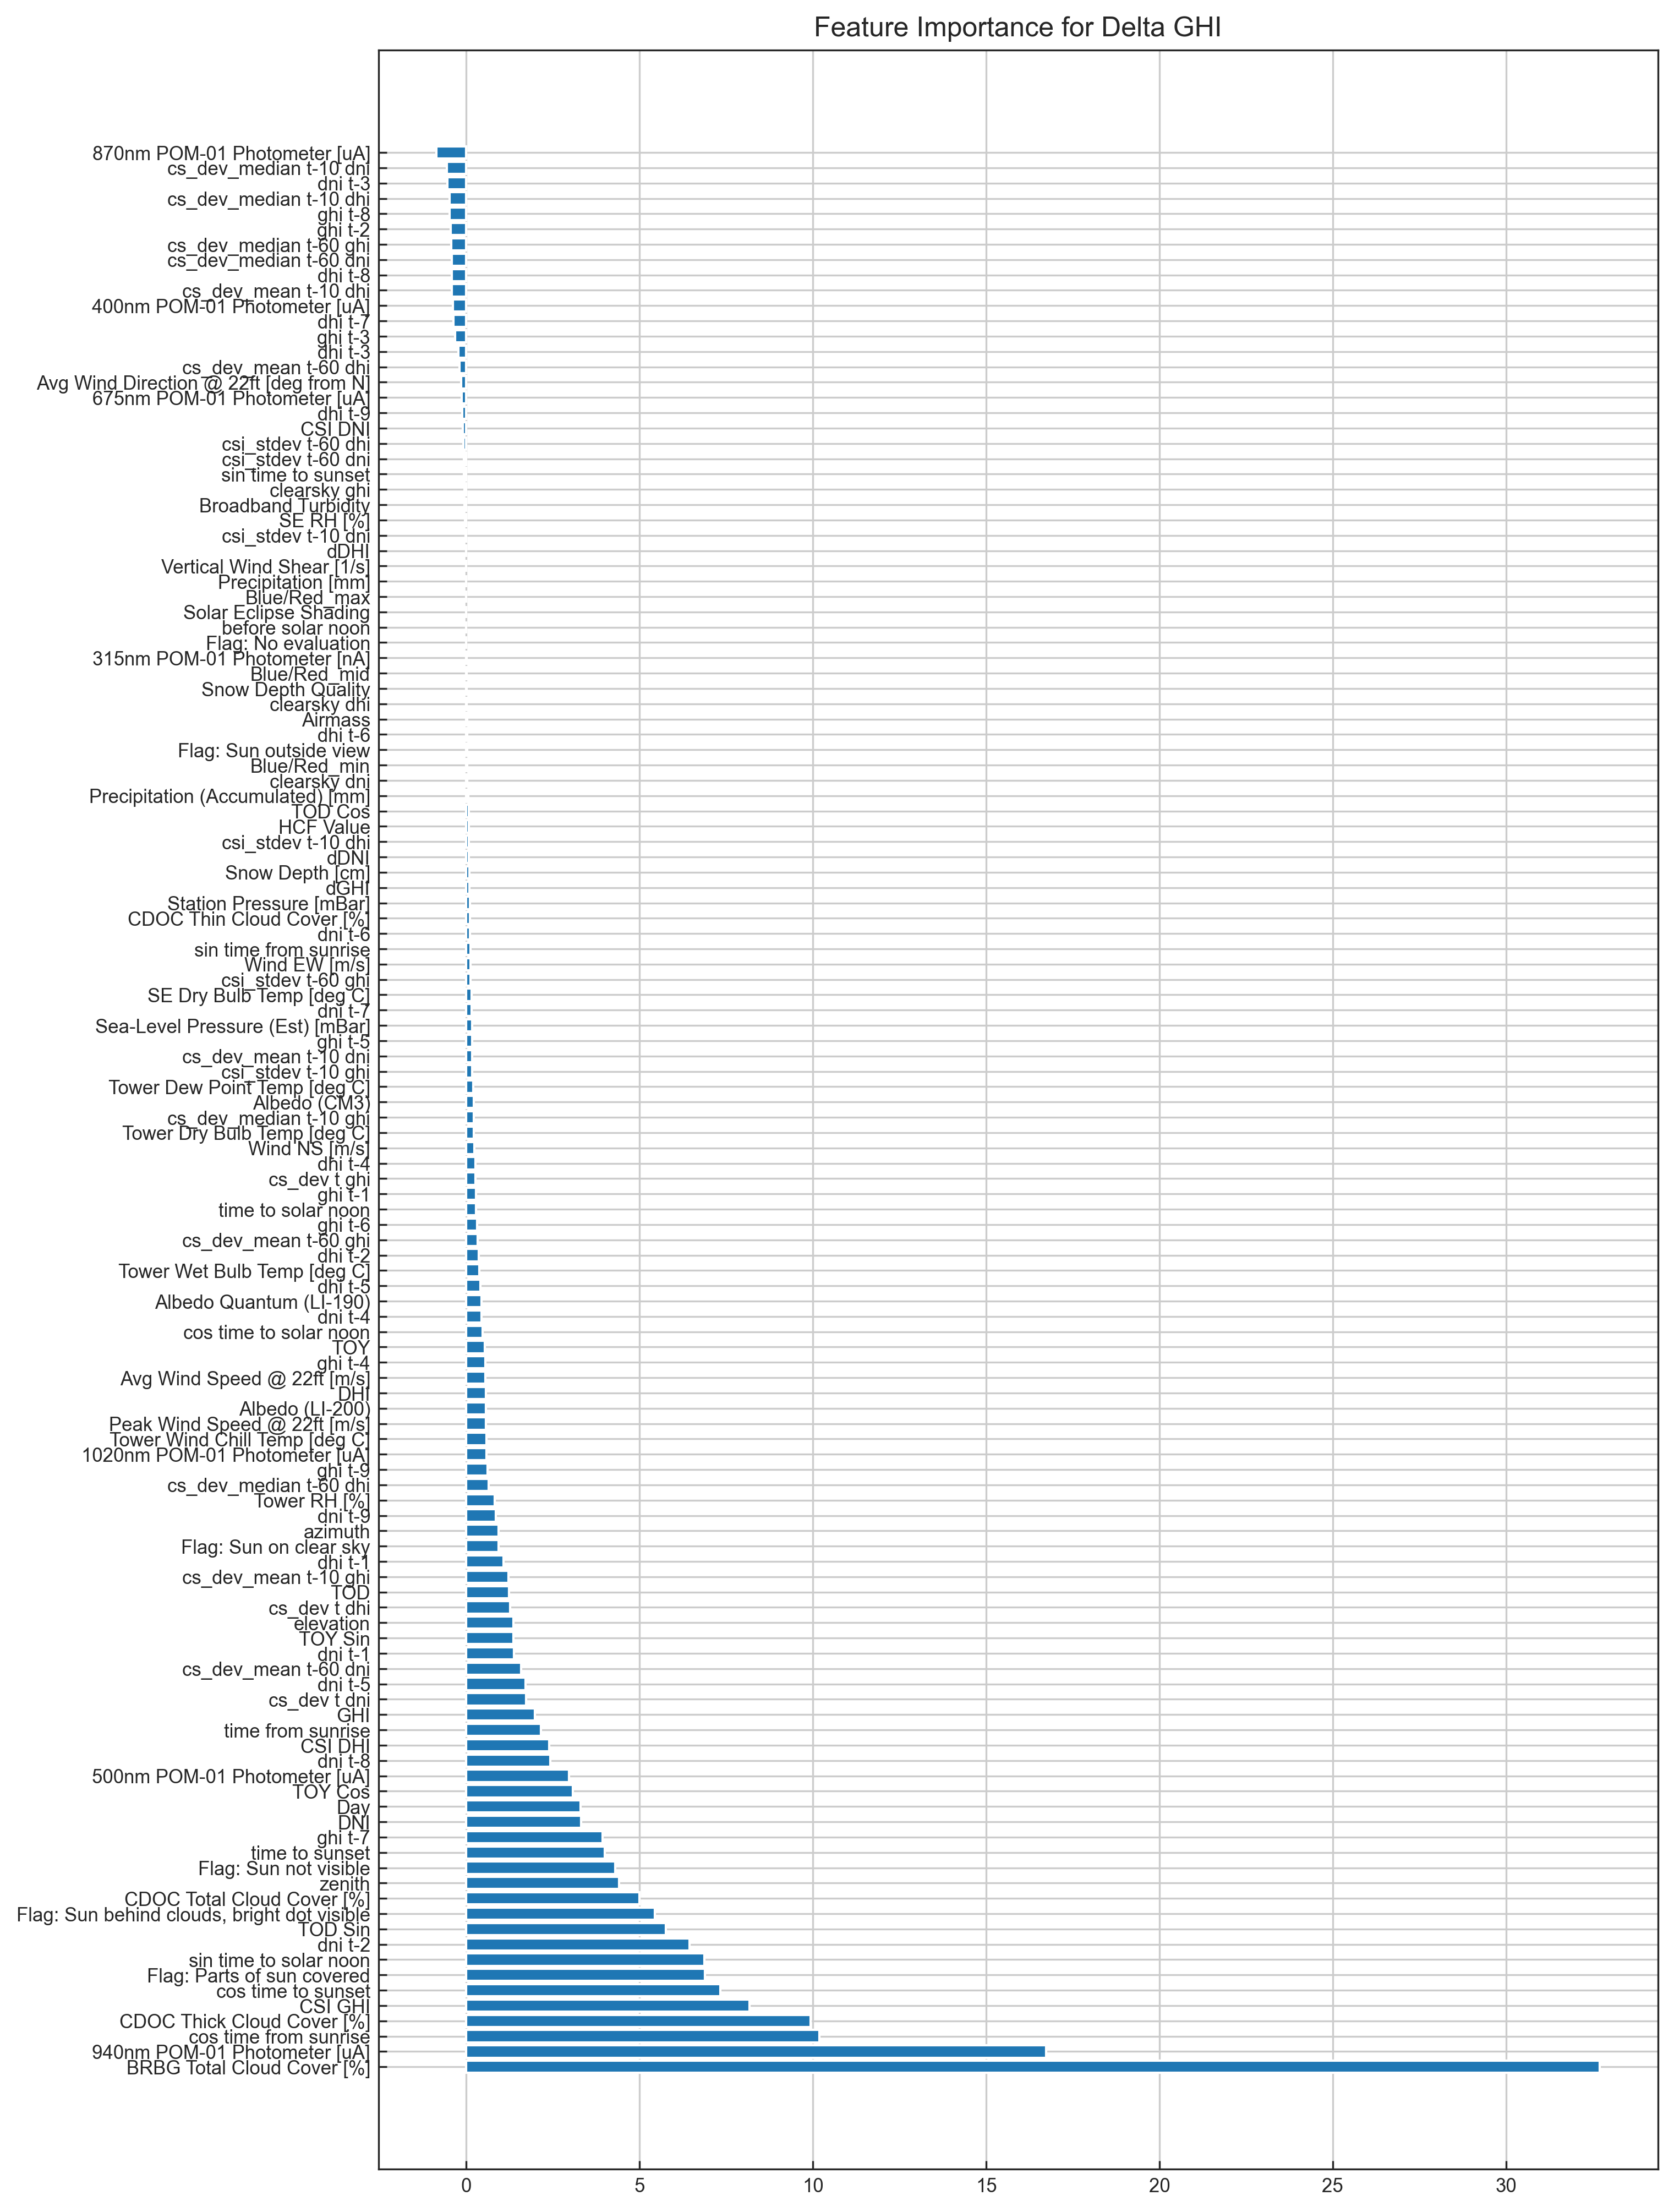

cs_dev t ghi
====== Reading windows from cache ======

Done


c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:774: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_datetimes = datetimes[train_mask]
c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:775: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  validate_datetimes = datetimes[validate_mask]


Train windows: 47108

self.train_dates.shape=(47108, 25)

self.train_past_features.shape=(47108, 13, 126)

self.train_future_features.shape=(47108, 12, 0)

self.train_scalar_responses.shape=(47108, 12, 1)

self.train_relative_responses.shape=(47108, 12, 0)

self.train_clear_sky_indexes.shape=(47108, 25)

self.train_clear_sky_irradiances.shape=(47108, 25)
Validate windows: 9155
loading model
	model loaded
Evaluating error metrics
287/287 [==============================] - 1s 3ms/step


  0%|          | 0/126 [00:00<?, ?it/s]

GHI 0
287/287 [==============================] - 1s 3ms/step
Importance: 0.508632271386432
DNI 1
287/287 [==============================] - 1s 2ms/step
Importance: 4.242303529107446
DHI 2
287/287 [==============================] - 1s 2ms/step
Importance: 0.1291139122013618
ghi t-1 3
287/287 [==============================] - 1s 3ms/step
Importance: 0.9571547689362063
ghi t-2 4
287/287 [==============================] - 1s 3ms/step
Importance: 0.14295186512120495
ghi t-3 5
287/287 [==============================] - 1s 3ms/step
Importance: 0.1887145339903924
ghi t-4 6
287/287 [==============================] - 1s 3ms/step
Importance: 0.3867723052835146
ghi t-5 7
287/287 [==============================] - 1s 3ms/step
Importance: 0.25929040572673046
ghi t-6 8
287/287 [==============================] - 1s 2ms/step
Importance: 0.3161292561607496
ghi t-7 9
287/287 [==============================] - 1s 3ms/step
Importance: 1.589509192289455
ghi t-8 10
287/287 [==============================] -

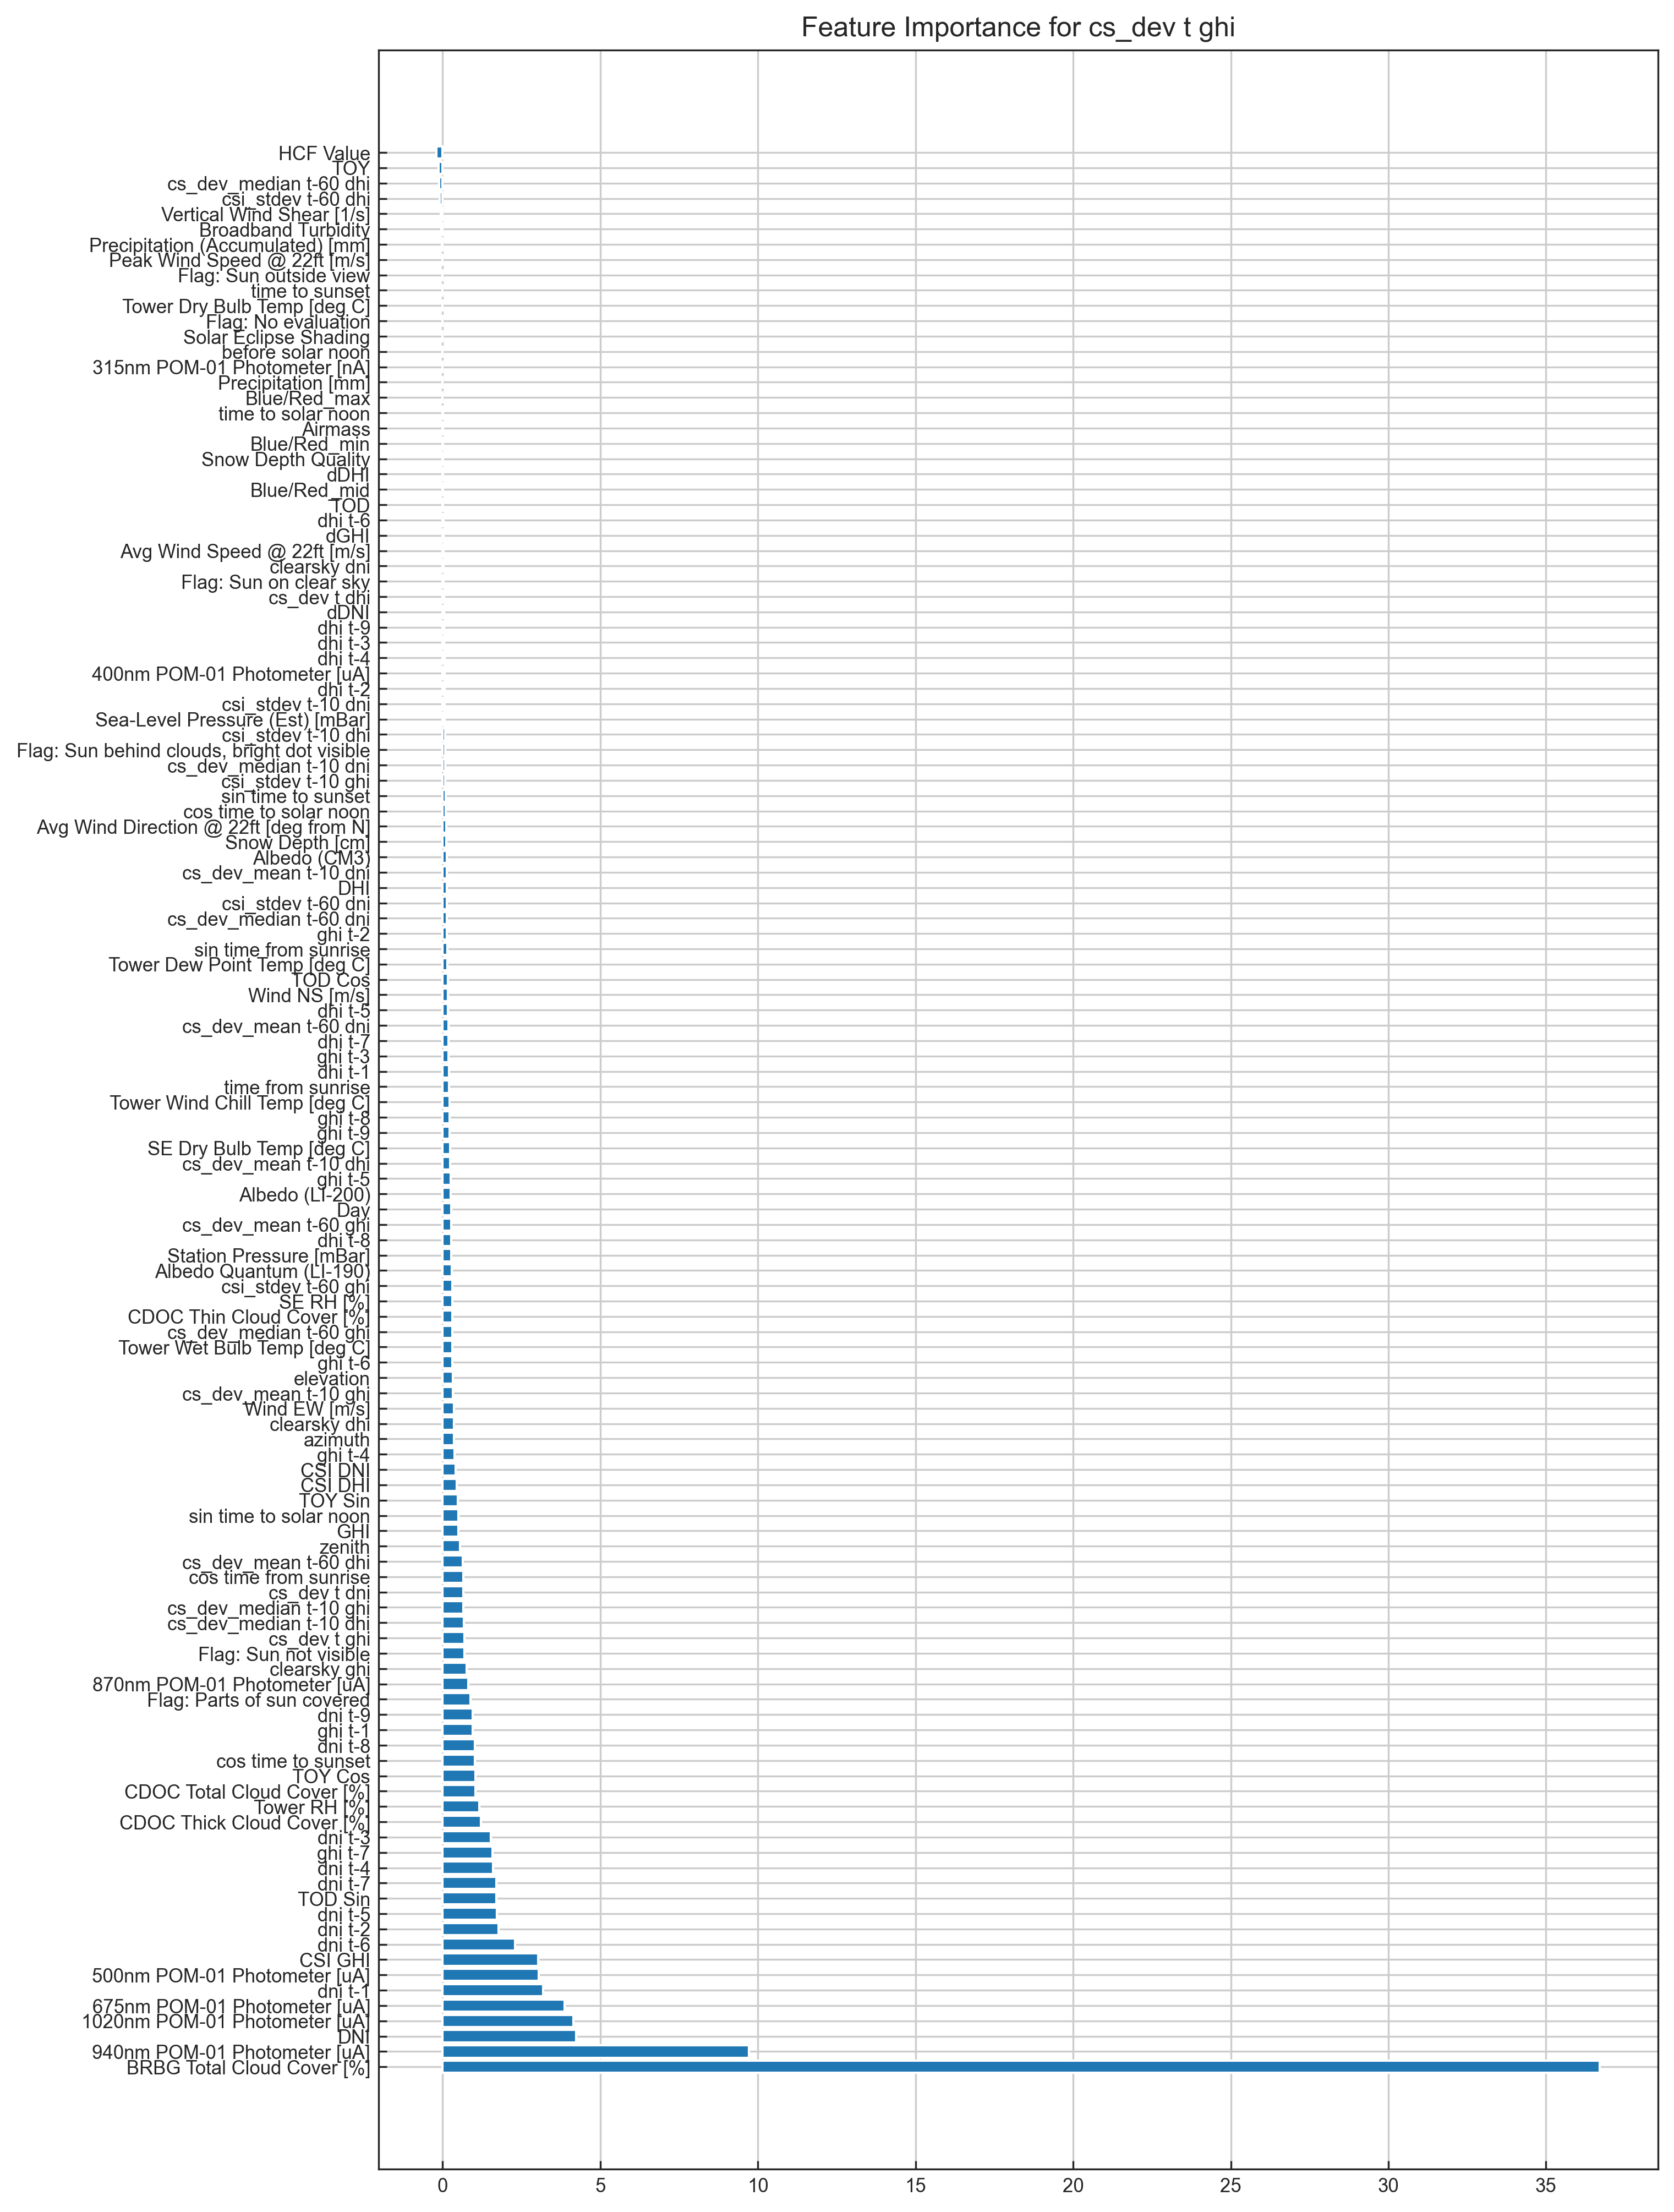

CSI GHI
====== Reading windows from cache ======

Done


c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:774: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_datetimes = datetimes[train_mask]
c:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\SolarProphet\solarprophet.py:775: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  validate_datetimes = datetimes[validate_mask]


Train windows: 47108

self.train_dates.shape=(47108, 25)

self.train_past_features.shape=(47108, 13, 126)

self.train_future_features.shape=(47108, 12, 0)

self.train_scalar_responses.shape=(47108, 12, 1)

self.train_relative_responses.shape=(47108, 12, 0)

self.train_clear_sky_indexes.shape=(47108, 25)

self.train_clear_sky_irradiances.shape=(47108, 25)
Validate windows: 9155
loading model
	model loaded
Evaluating error metrics
287/287 [==============================] - 1s 3ms/step


  0%|          | 0/126 [00:00<?, ?it/s]

GHI 0
287/287 [==============================] - 1s 3ms/step
Importance: 0.946560759213952
DNI 1
287/287 [==============================] - 1s 3ms/step
Importance: 1.020518719414227
DHI 2
287/287 [==============================] - 1s 3ms/step
Importance: 0.43331982313618767
ghi t-1 3
287/287 [==============================] - 1s 2ms/step
Importance: 0.46879039742091777
ghi t-2 4
287/287 [==============================] - 1s 2ms/step
Importance: 0.5547473300622556
ghi t-3 5
287/287 [==============================] - 1s 2ms/step
Importance: 0.297886789062332
ghi t-4 6
287/287 [==============================] - 1s 2ms/step
Importance: 0.21992680263390696
ghi t-5 7
287/287 [==============================] - 1s 3ms/step
Importance: 0.17575696731417167
ghi t-6 8
287/287 [==============================] - 1s 3ms/step
Importance: 0.3058901468055808
ghi t-7 9
287/287 [==============================] - 1s 3ms/step
Importance: 0.7692131253313335
ghi t-8 10
287/287 [==============================]

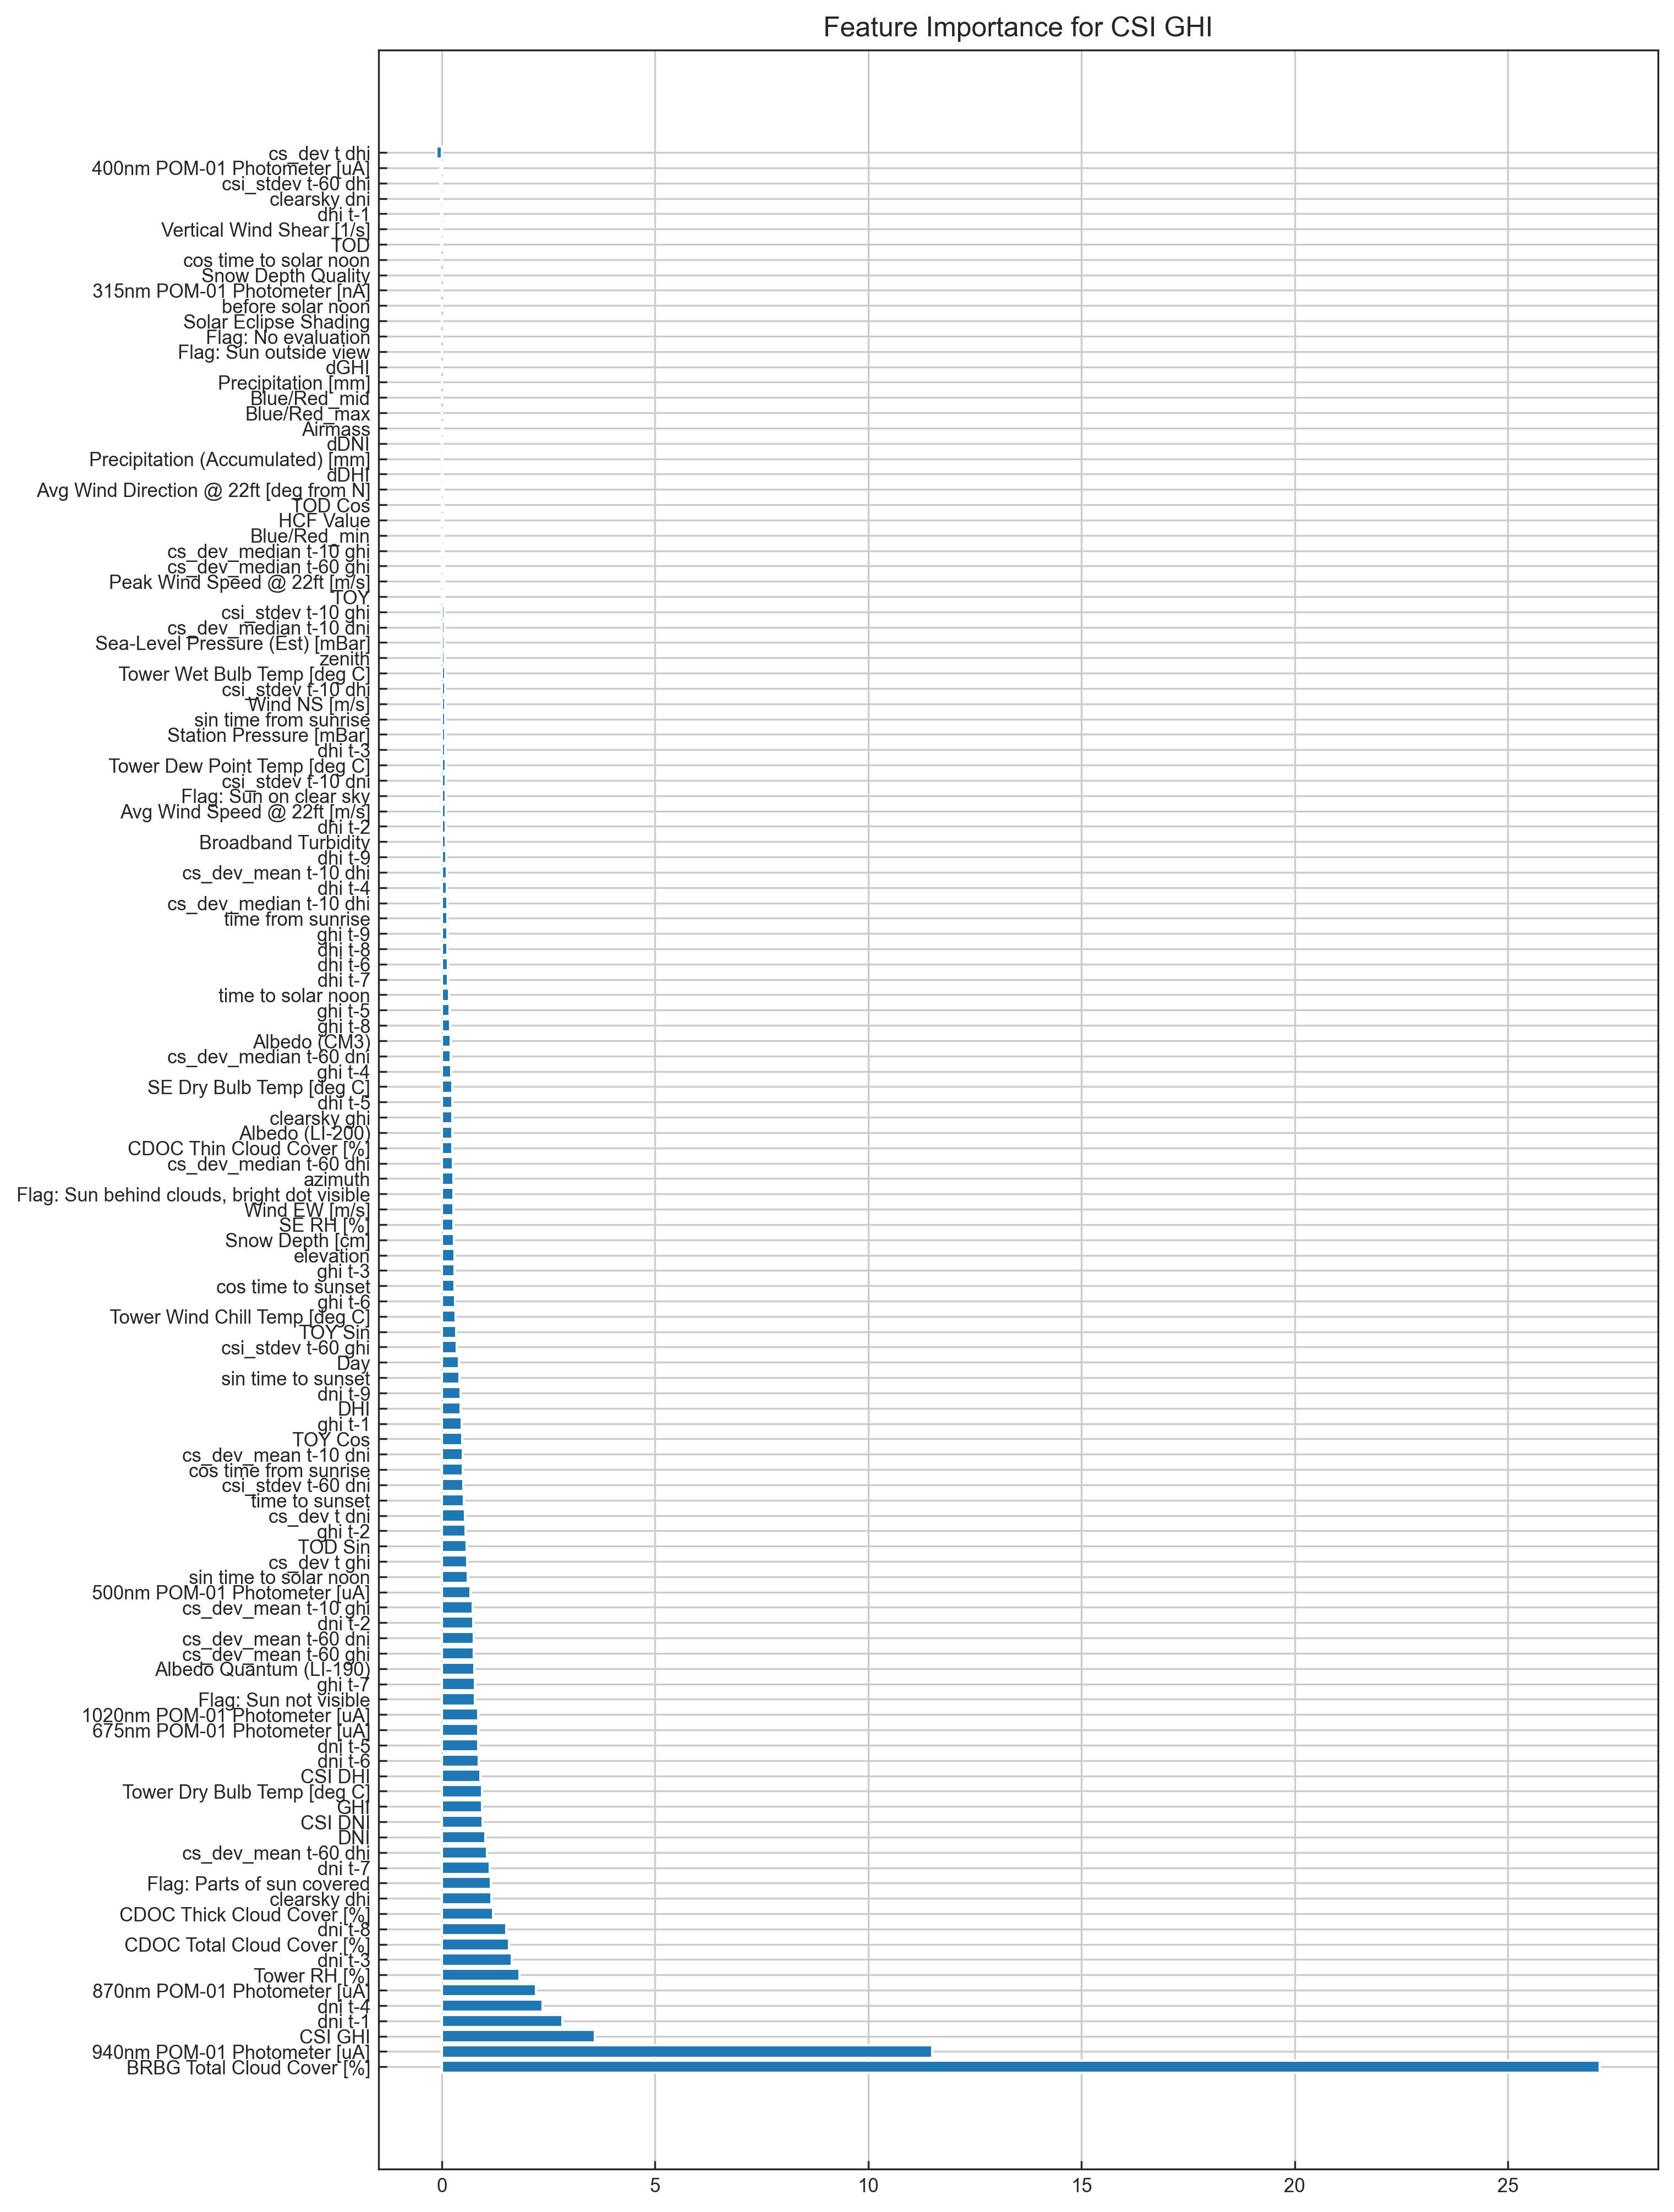

In [ ]:
# iterate through all 5 response variables
# Model target and path
model_runs = {
    "GHI": "SOL-8",
    "Delta CSI GHI": "SOL-9",
    "Delta GHI": "SOL-48",  # two points did not converge in first trial
    "cs_dev t ghi": "SOL-11",
    "CSI GHI": "SOL-12",
}

cv_selection = 3

for selected_target in model_runs.keys():
    print(selected_target)
    # Initialize a class object
    tt = TabularTest(
        # Required Parameters
        n_steps_in=13,
        n_steps_out=12,
        selected_features=None,
        selected_groups=constants.FEATURE_GROUPS,
        selected_responses=[selected_target],
        scaler_type="minmax",
        data_path=constants.JOINT_DATA_H5_PATH,
        ## Saving and cache parameters (optional)
        model_save_path="results",
        datetimes_cache_path=constants.DATETIME_VALUES_PATH,
        window_cache_path=os.path.join("data", "windows_cache.h5"),
        all_past_features=constants.PAST_FEATURES,
        all_future_features=constants.FUTURE_FEATURES,
        all_scalar_responses=constants.SCALAR_RESPONSES,
        all_relative_responses=constants.RELATIVE_RESPONSES,
        # Model (optional)
        model=None,
        model_name="TimeDistributed_CNN-LSTM-MLP",
        # Optimizer and training tuning parameters (optional)
        scale_responses=True,
        epochs=2000,
        shuffle_training_order=False,
        batch_size=5000,
        loss="mse",
        optimizer=None,
        learning_rate=0.001,  # this should be static or a tf.optimizers.schedules object
        callbacks=[],
        early_stopping=True,
        stopping_patience=500,
        stopping_min_delta=1e-4,
        metrics=[],  # todo possibly replace
        fit_verbose=1,
        # Utility Parameters (optional)
        data_cols=constants.DATA_COLS,
        feature_groups=constants.FEATURE_GROUPS,
        scalar_response=constants.SCALAR_RESPONSES,
        relative_response=constants.RELATIVE_RESPONSES,
        seed=42,
        n_job_workers=10,
        # Neptune Parameters (optional)
        neptune_log=False,
        neptune_run_name=None,
        tags=None,
    )

    # Load data windows
    tt.import_preprocess_cached_windows(
        train_validate_date="2021-09-27", end_date="2022-09-27", verbose=True
    )

    # Load model
    print("loading model")
    model_path = os.path.join(
        "results", model_runs[selected_target] + f"_CV{cv_selection}"
    )
    tt.model = tf.keras.models.load_model(
        model_path,
        options=tf.saved_model.LoadOptions(experimental_io_device="/job:localhost"),
    )
    print("\tmodel loaded")

    # Get baseline
    print("Evaluating error metrics")
    train_prediction = tt.model.predict(tt.train_past_features)
    val_prediction = tt.model.predict(tt.validate_past_features)

    # rescale to GHI units
    train_prediction_rescaled = tt.rescale_to_GHI(
        train_prediction, tt.train_clear_sky_irradiances, tt.train_clear_sky_indexes
    )
    validate_prediction_rescaled = tt.rescale_to_GHI(
        val_prediction, tt.validate_clear_sky_irradiances, tt.validate_clear_sky_indexes
    )
    train_true_rescaled = tt.rescale_to_GHI(
        tt.y_train_true, tt.train_clear_sky_irradiances, tt.train_clear_sky_indexes
    )
    validate_true_rescaled = tt.rescale_to_GHI(
        tt.y_validate_true,
        tt.validate_clear_sky_irradiances,
        tt.validate_clear_sky_indexes,
    )

    # calculate the error metrics
    tt.final_error_metrics(False)

    # save baseline stats
    baseline_stats = tt.run.copy()

    # permute features
    permutation_results = {}

    unpermuted_train_past_features = tt.train_past_features.copy()
    unpermuted_validate_past_features = tt.validate_past_features.copy()

    for i, feature_name in enumerate(tqdm(tt.selected_features)):
        print(f"{feature_name} {i}")
        # TODO it would be better to make a deep copy perhaps
        # restore the original inputs
        tt.train_past_features = unpermuted_train_past_features.copy()
        tt.validate_past_features = unpermuted_validate_past_features.copy()

        # shuffle ith feature in input arrays
        rng.shuffle(tt.train_past_features[:, :, i])
        rng.shuffle(tt.validate_past_features[:, :, i])

        # evaluate_model
        tt.final_error_metrics(
            False
        )  # evaluate prediciton, rescale to GHI, calculate error metrics
        print(f"Importance: {tt.run['Validate MAE'] - baseline_stats['Validate MAE']}")
        permutation_results[feature_name] = tt.run.copy()

    feature_permutation_score = np.zeros(len(tt.selected_features))

    for i, feature in enumerate(tt.selected_features):
        feature_permutation_score[i] = (
            permutation_results[feature]["Validate MAE"]
            - baseline_stats["Validate MAE"]
        )  # higher is better
        # print(f"{feature}: {permutation_results[feature]['Validate MAE']}")

    feature_importance_order = np.argsort(feature_permutation_score)[::-1]

    # sort array and list of feature names
    feature_permutation_score = feature_permutation_score[feature_importance_order]
    sorted_feature_names = [tt.selected_features[i] for i in feature_importance_order]

    fig, ax = plt.subplots(figsize=(10, 17), dpi=300)
    ax.barh(
        y=range(len(sorted_feature_names)),
        width=feature_permutation_score,
        tick_label=sorted_feature_names,
    )
    ax.grid()
    plt.title(f"Feature Importance for {selected_target}")
    fig.savefig(
        os.path.join(
            "results",
            "feature_importance",
            f"feature_importance_{selected_target}_CV{cv_selection}_iteration1.png",
        )
    )
    plt.show()

    permutation_df = pd.DataFrame(
        index=sorted_feature_names,
        data=feature_permutation_score,
        columns=["Feature Importance"],
    )
    save_path = os.path.join(
        "results",
        "feature_importance",
        f"feature_importance_{selected_target}_CV{cv_selection}_iteration1.csv",
    )
    permutation_df = pd.DataFrame(
        index=sorted_feature_names,
        data=feature_permutation_score,
        columns=["Feature Importance"],
    )
    permutation_df.to_csv(save_path)

In [18]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

iteration1_path = os.path.join("results", "feature_importance", "iteration1.csv")
iteration1_df = pd.read_csv(iteration1_path)
iteration1_df["total"] = iteration1_df[
    ["Clear Sky Deviation", "Clear Sky Index", "Delta Irradiance", "Irradiance"]
].mean(axis=1)
iteration1_df.sort_values(by="total", ascending=False, inplace=True)
iteration1_df = iteration1_df.head(30)
df2 = iteration1_df[["Feature", "total"]]
iteration1_df.pop("total")

df = iteration1_df.melt(
    "Feature", var_name="Target Variable", value_name="Feature Importance"
)
df2["total"] = df2["total"] / 75 * 100
df2 = df2.melt("Feature", var_name="Target Variable", value_name="Feature Importance")

fig, ax = plt.subplots(figsize=(8, 8), dpi=1_000)
sns.barplot(
    data=df2,
    y="Feature",
    x="Feature Importance",
    hue="Target Variable",
    ax=ax,
    zorder=3,
)
ax.grid(zorder=0)
plt.xticks()
ax.set_xlabel("Mean Absolute Error Reduction (%)")
ax.set_title("Permutation Feature Importance")
plt.show()

/var/folders/s5/91gspn4x2j9c_j33qvjvrlt00000gn/T/ipykernel_85157/2864216363.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["total"] = df2["total"] / 75 * 100
